In [1]:
from datetime import datetime
# from dateutil.relativedelta import relativedelta
import math
from marketdatalib import map_scrip_to_yfin_ticker, get_nifty_index_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean
# from scipy.optimize import minimize

In [2]:
# Number of year of historic data to consider
YEARS_OF_HISTORY = 15

# The risk free return rate. This is often the return on a 10 year government bond.
# At present, the 10 year government bond rate is 6.84%. We are using 7.5% for the sake of simplicity which is the rate of a fixed deposit.
RISK_FREE_RETURN = 0.0735
EXPECTED_MARKET_RETURN = 0.12
ACCEPTABLE_VOLATILITY = 0.15


INDIAN_ETFS = [
    'NIFTY 50',
    'NIFTY 500',
    # 'NIFTY MIDCAP 150',
    'NIFTY NEXT 50',
    'NIFTY50 VALUE 20'
    ]
INDIAN_ETFS

['NIFTY 50', 'NIFTY 500', 'NIFTY NEXT 50', 'NIFTY50 VALUE 20']

In [3]:
master_data = pd.DataFrame()

for ind in INDIAN_ETFS:
    index_data = get_nifty_index_data(index_name=ind, number_of_years=YEARS_OF_HISTORY)['Close']
    index_data = pd.Series(index_data)
    index_data = index_data.to_frame(name=ind)
    master_data = master_data.combine_first(index_data)

# For every column in the master_data, add a new columns with name <column_name>_returns containting percentage returns compared to previous day
# It is in the form of (current_price - previous_price) / previous_price (not 1 + r format) and hence additive
for column in master_data:
    master_data[column + '_Return'] = master_data[column].pct_change() + 1

master_data = master_data.dropna()

master_data

,NIFTY 50,NIFTY 500,NIFTY NEXT 50,NIFTY50 VALUE 20,NIFTY 50_Return,NIFTY 500_Return,NIFTY NEXT 50_Return,NIFTY50 VALUE 20_Return
Date,,,,,,,,
2015-11-10,7783.35,6536.45,19311.30,3507.00,0.983342,0.984198,0.981268,0.984532
2015-11-11,7825.00,6585.15,19509.90,3527.25,1.005351,1.007451,1.010284,1.005774
2015-11-13,7762.25,6526.60,19268.90,3502.30,0.991981,0.991109,0.987647,0.992927
2015-11-16,7806.60,6551.45,19163.40,3506.90,1.005714,1.003807,0.994525,1.001313
2015-11-17,7837.55,6580.80,19275.90,3504.35,1.003965,1.004480,1.005871,0.999273
...,...,...,...,...,...,...,...,...
2025-02-01,23482.15,21581.75,63503.10,13156.50,0.998883,1.000039,1.005952,0.995061
2025-02-03,23361.05,21402.55,62634.20,13059.40,0.994843,0.991697,0.986317,0.992620
2025-02-04,23739.25,21727.45,63598.35,13235.50,1.016189,1.015180,1.015393,1.013485


### Do keep in mind that it is extremely important to check for normality of the returns. This is because most of the financial models assume that the returns are normally distributed. If the returns are not normally distributed, then the calculations and projections made on the ba of historic mean and standard deviations will not hold true.

#### _Visual Inspection_
Histogram: Plot a histogram of the data and visually inspect the shape.
Q-Q Plot (Quantile-Quantile Plot): Plot the quantiles of the data against the quantiles of a normal distribution.

#### _Statistical Tests_
Shapiro-Wilk Test: A widely used test for normality.
Kolmogorov-Smirnov Test: Another test for normality, though less powerful than the Shapiro-Wilk test.
Anderson-Darling Test: A test that gives more weight to the tails of the distribution.
D'Agostino's K-squared Test: A test based on transformations of the data.

In [4]:
def expected_return(market_return, risk_free_return, beta, weight = 1):
    """
    Calculate the expected return of a portfolio using the Capital Asset Pricing Model (CAPM).

    Parameters:
    market_return (float): The expected return of the market. Often the return of a broader index like NIFTY 500
    risk_free_return (float): The risk-free rate of return. 10 year government bond rate is often used, or the FD rate.
    beta (float): The beta of the portfolio, representing its sensitivity to market movements.
    weight (float, optional): The weight of the portfolio. Default is 1.

    Returns:
    float: The expected return of the portfolio.
    """
    return risk_free_return + weight * beta * (market_return - risk_free_return)



Let us assume that NIFTY 500 represents the total market for the sake of brevity. It represnts the universe of stocks that are investable in Indian equity market

In [5]:
benchmark_returns = master_data['NIFTY 500_Return']

R_m = gmean(benchmark_returns) ** 252 - 1

Sigma_m = np.std(benchmark_returns - 1) * np.sqrt(252)

print(f"Market/Benchmark Return: {R_m}")
print(f"Market/Benchmark Volatility: {Sigma_m}")


Market/Benchmark Return: 0.13442964375815247
Market/Benchmark Volatility: 0.16114768656088363


To start with, let us start with a single security portfolio. The portfolio is constructed with NIFTY50 VALUE 20 index.

In [6]:
portfolio_indices = ['NIFTY50 VALUE 20']

In [7]:
from finlib import plot_capital_market_line, calculate_beta, calculate_cagr_of_security

In [13]:
returns_matrix = pd.DataFrame(index=portfolio_indices, columns=['Annualized Return', 'Beta', 'Volatility', 'Absolute Return', 'Sharpe Ratio'])

for index in portfolio_indices:
    index_returns = gmean(master_data[index + '_Return']) ** 252 - 1
    
    # Returns include investment amout + absolute returns
    returns_matrix.loc[index, 'Annualized Return'] = index_returns

    returns_matrix.loc[index, 'Beta'] = calculate_beta(master_data[index + '_Return'], benchmark_returns)
    returns_matrix.loc[index, 'Volatility'] = np.std(master_data[index + '_Return'] - 1) * np.sqrt(252)
    
    # Absolute return
    returns_matrix.loc[index, 'Absolute Return'] = RISK_FREE_RETURN + returns_matrix.loc[index, 'Beta'] * (R_m - RISK_FREE_RETURN)
    returns_matrix.loc[index, 'Sharpe Ratio'] = (index_returns - RISK_FREE_RETURN) / returns_matrix.loc[index, 'Volatility']

returns_matrix

,Annualized Return,Beta,Volatility,Absolute Return,Sharpe Ratio
NIFTY50 VALUE 20,0.149649,0.841496,0.156886,0.124772,0.485378


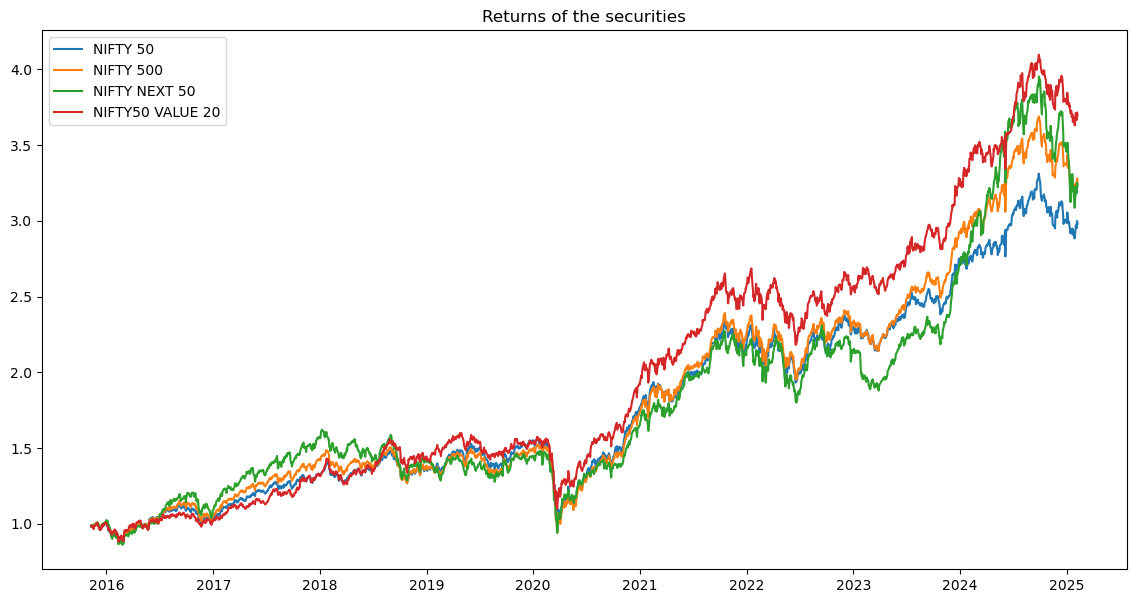

In [9]:
plt.figure(figsize=(14, 7))
for column in master_data:
    if '_Return' in column:
        plt.plot(master_data[column].cumprod(), label=column.rstrip('_Return'))
plt.legend()
plt.title('Returns of the securities')
plt.show()

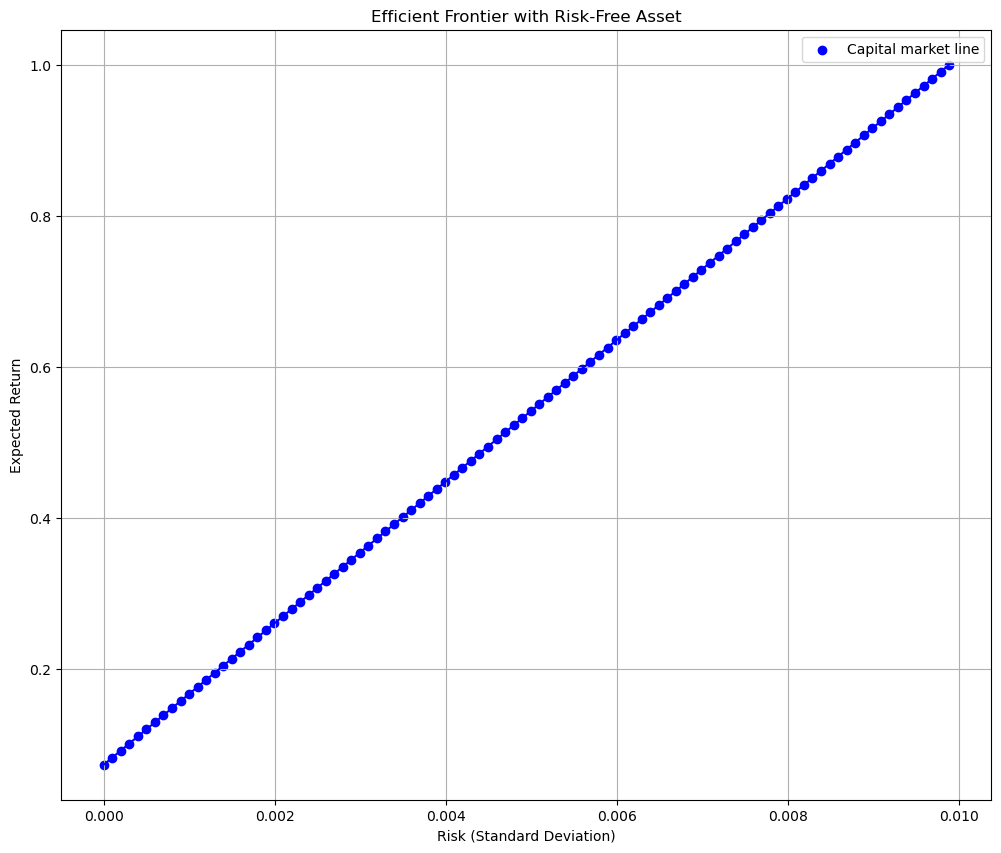

In [10]:
ACCEPTABLE_VOLATILITY = 0.15
coefficients = list(plot_capital_market_line(RISK_FREE_RETURN, master_data['NIFTY50 VALUE 20_Return'], ACCEPTABLE_VOLATILITY))

The efficient frontier curve can be a straight line when combining a risk-free asset with a single risky asset. This straight line is known as the Capital Market Line (CML). The CML represents the risk-return trade-off of a portfolio that combines a risk-free asset with a market portfolio.

This also means that in this case, the risk of the portfolio is a linear function of the risk of the risky asset, since the risk of the risk free asset is zero. Hence, irrespective of the weight of the risky asset

In [11]:
cagr_return = calculate_cagr_of_security(master_data['NIFTY50 VALUE 20'])
print(f"CAGR return of NIFTY50 VALUE 20: {round(cagr_return.item(), 2)}%")

CAGR return of NIFTY50 VALUE 20: 15.39%


Note that the CAGR return above is the return of the security from past. Not te expected return. Past returns are by no means indicative of future returns.

The expected return is a function of past returns, but also of the risk-free rate and the risk premium and inflation. The purchasing power of money decreases over time due to inflation.

The risk premium is the return that investors expect to receive for taking on additional risk. The risk premium is calculated as the difference between the expected return of the risky asset and the risk-free rate.

In [12]:
coefficients

# (weights, portfolio_returns, portfolio_risks)

[(0.0, 0.0735, 0.0),
 (0.010101010101010102, 0.08286465945408704, 9.972205639849375e-05),
 (0.020202020202020204, 0.09222931890817407, 0.0001994441127969875),
 (0.030303030303030304, 0.10159397836226111, 0.00029916616919548126),
 (0.04040404040404041, 0.11095863781634815, 0.000398888225593975),
 (0.05050505050505051, 0.1203232972704352, 0.0004986102819924688),
 (0.06060606060606061, 0.1296879567245222, 0.0005983323383909625),
 (0.07070707070707072, 0.13905261617860926, 0.0006980543947894564),
 (0.08080808080808081, 0.1484172756326963, 0.00079777645118795),
 (0.09090909090909091, 0.15778193508678334, 0.0008974985075864437),
 (0.10101010101010102, 0.16714659454087039, 0.0009972205639849376),
 (0.11111111111111112, 0.17651125399495743, 0.0010969426203834313),
 (0.12121212121212122, 0.18587591344904444, 0.001196664676781925),
 (0.13131313131313133, 0.19524057290313152, 0.0012963867331804188),
 (0.14141414141414144, 0.20460523235721856, 0.0013961087895789127),
 (0.15151515151515152, 0.21396

In [18]:
np.std(master_data['NIFTY50 VALUE 20_Return']) * np.linspace(0, 1, 100)

array([0.00000000e+00, 9.97220564e-05, 1.99444113e-04, 2.99166169e-04,
       3.98888226e-04, 4.98610282e-04, 5.98332338e-04, 6.98054395e-04,
       7.97776451e-04, 8.97498508e-04, 9.97220564e-04, 1.09694262e-03,
       1.19666468e-03, 1.29638673e-03, 1.39610879e-03, 1.49583085e-03,
       1.59555290e-03, 1.69527496e-03, 1.79499702e-03, 1.89471907e-03,
       1.99444113e-03, 2.09416318e-03, 2.19388524e-03, 2.29360730e-03,
       2.39332935e-03, 2.49305141e-03, 2.59277347e-03, 2.69249552e-03,
       2.79221758e-03, 2.89193964e-03, 2.99166169e-03, 3.09138375e-03,
       3.19110580e-03, 3.29082786e-03, 3.39054992e-03, 3.49027197e-03,
       3.58999403e-03, 3.68971609e-03, 3.78943814e-03, 3.88916020e-03,
       3.98888226e-03, 4.08860431e-03, 4.18832637e-03, 4.28804843e-03,
       4.38777048e-03, 4.48749254e-03, 4.58721459e-03, 4.68693665e-03,
       4.78665871e-03, 4.88638076e-03, 4.98610282e-03, 5.08582488e-03,
       5.18554693e-03, 5.28526899e-03, 5.38499105e-03, 5.48471310e-03,
      

In [16]:
master_data['NIFTY50 VALUE 20_Return'] * np.linspace(0, 1, 100)

Date
2015-11-10    0.984532
2015-11-11    1.005774
2015-11-13    0.992927
2015-11-16    1.001313
2015-11-17    0.999273
                ...   
2025-02-01    0.995061
2025-02-03    0.992620
2025-02-04    1.013485
2025-02-05    0.998651
2025-02-06    0.996486
Name: NIFTY50 VALUE 20_Return, Length: 2368, dtype: float64

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747